In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import copy
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

## Data reconstruction:  RegularizedInversion,  NormalEquationsInversion, ISTA , FISTA

Dot test passed, v^H(Opu)=1.9084068051887275 - u^H(Op^Hv)=1.9084068051887284
Dot test passed, v^H(Opu)=3.9281602909179507 - u^H(Op^Hv)=3.928160290917951


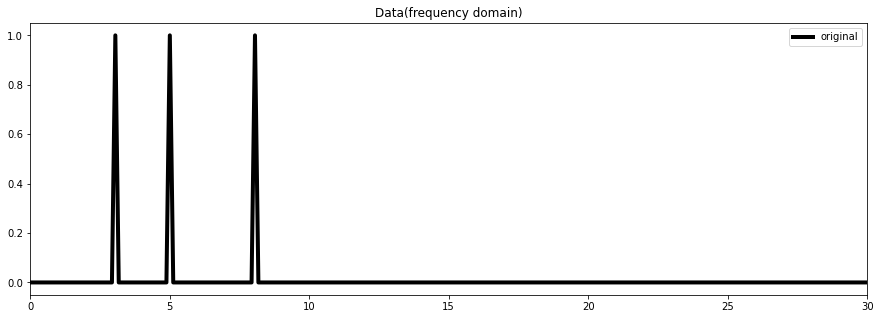

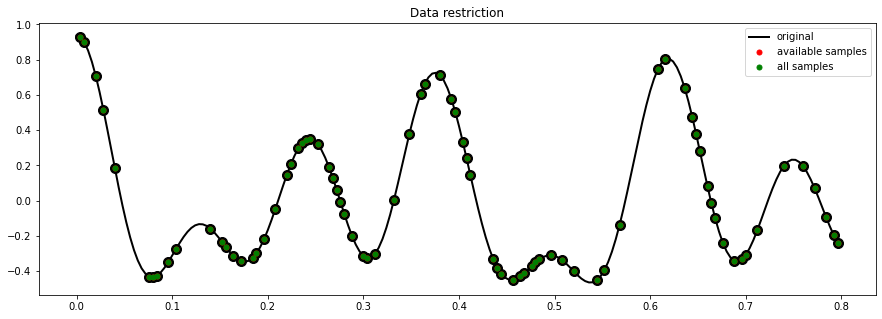

In [2]:
np.random.seed(10)

# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = cp.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(cp.asnumpy(X)), 'k', lw=4, label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling = 0.4
Nsub = int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop, Nsub, N, verb=True)

Rop_cp = Restriction(N, iava, dtype='float64')
dottest(Rop_cp, Nsub, N, verb=True, backend='cupy')

y = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t, cp.asnumpy(x), 'k' , lw=2, label='original')
plt.plot(t[iava], cp.asnumpy(x)[iava], '.k', ms=20)
plt.plot(t[iava], cp.asnumpy(y), '.r', ms=10, label='available samples')
plt.plot(t, ymask, '.g', ms=10, label='all samples')
plt.legend()
plt.title('Data restriction');

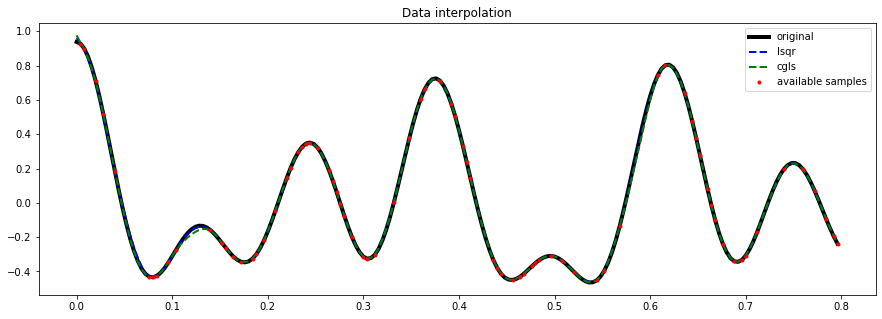

In [3]:
# Create regularization operator
D2op  = SecondDerivative(N, dtype='float64')

# Invert for interpolated signal
xlsqr_reg_lop, istop, itn, r1norm, r2norm = \
    regularized_inversion(Rop, cp.asnumpy(y), [D2op], epsRs=[np.sqrt(0.1)],
                          **dict(damp=np.sqrt(1e-4), iter_lim=200, show=0))

xcgls_reg_lop = \
    regularized_inversion(Rop_cp, y, [D2op], epsRs=[np.sqrt(0.5)],
                          **dict(engine='pylops', damp=np.sqrt(1e-4), niter=200, show=0))[0]

fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),             'k'   , lw=4,   label='original')
plt.plot(t,       cp.asnumpy(xlsqr_reg_lop), '--b' , lw=2,   label='lsqr')
plt.plot(t,       cp.asnumpy(xcgls_reg_lop), '--g' , lw=2,   label='cgls')
plt.plot(t[iava], cp.asnumpy(y),             '.r'  , lw=20,  label='available samples')
plt.legend()
plt.title('Data interpolation');

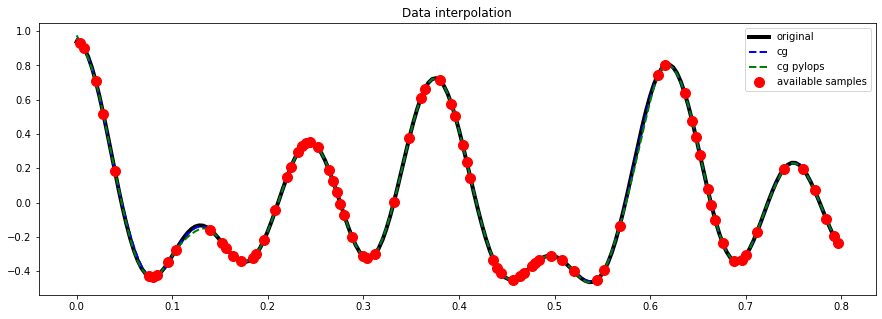

In [4]:
epsR=np.sqrt(0.1)
epsI=np.sqrt(1e-4)
x_cg_lop, istop = normal_equations_inversion(Rop, cp.asnumpy(y), [D2op], epsI=epsI, epsRs=[epsR],
                                             **dict(maxiter=200))
epsR=np.sqrt(0.4)
epsI=np.sqrt(1e-4)
x_cgls_lop, istop = normal_equations_inversion(Rop_cp, y, [D2op], epsI=epsI, epsRs=[epsR],
                                               **dict(engine='pylops', niter=200))

fig = plt.figure(figsize=(15,5))
plt.plot(t, cp.asnumpy(x), 'k', lw=4, label='original')
plt.plot(t, x_cg_lop, '--b', lw=2, label='cg')
plt.plot(t, cp.asnumpy(x_cgls_lop), '--g', lw=2, label='cg pylops')
plt.plot(t[iava], cp.asnumpy(y), '.r', ms=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


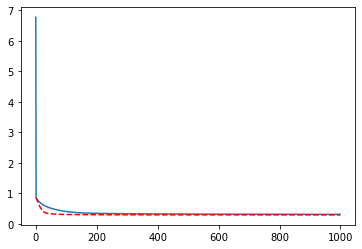

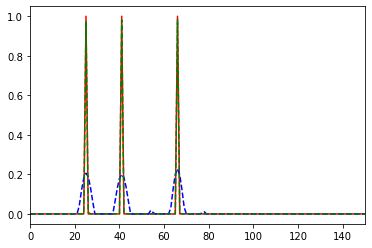

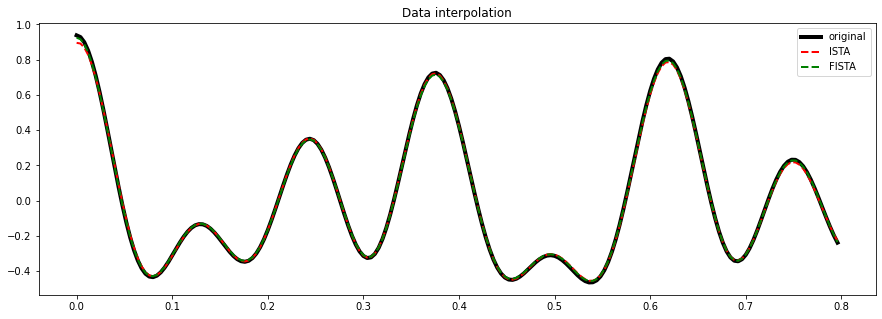

In [5]:
Xinv, niter, cost = ista(Rop_cp*FFTop.H, y, niter=1000, eps=0.1, tol=1e-8, eigsdict=dict(niter=10), 
                         monitorres=False, show=False)
xinv = FFTop.H*Xinv

Xinv1, niter1, cost1 = fista(Rop_cp*FFTop.H, y, niter=1000, eps=0.1, tol=1e-8, eigsdict=dict(niter=10), show=False)
xinv1 = FFTop.H*Xinv1

plt.figure()
plt.plot(cost)
plt.plot(cost1, '--r')

plt.figure()
plt.plot(cp.asnumpy(X), 'r')
plt.plot(cp.asnumpy(Xinv), '--b')
plt.plot(cp.asnumpy(Xinv1), '--g')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, cp.asnumpy(x), 'k', lw=4, label='original')
plt.plot(t, cp.asnumpy(xinv), '--r' , lw=2, label='ISTA')
plt.plot(t, cp.asnumpy(xinv1), '--g' , lw=2, label='FISTA')
plt.legend()
plt.title('Data interpolation');

## IRLS model

In [6]:
np.random.seed(10)

nx = 100
nnz = 5
ny = 20

x = cp.zeros(nx)
inz = np.random.permutation(np.arange(nx))[:nnz]
x[inz] = cp.random.uniform(0, 10, nnz)

A = MatrixMult(cp.random.normal(0, 1, (ny, nx)))
y = A @ x

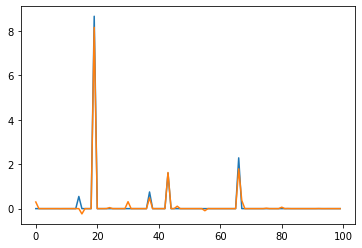

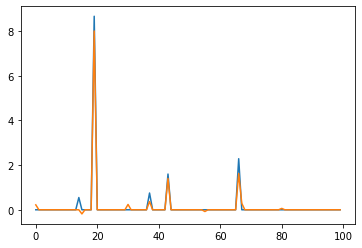

In [7]:
xinv = irls(A, y, nouter=20, epsI=0, kind='model', **dict(niter=10))[0]
plt.figure()
plt.plot(cp.asnumpy(x))
plt.plot(cp.asnumpy(xinv))

xinv = fista(A, y, niter=100, eps=10.)[0]
plt.figure()
plt.plot(cp.asnumpy(x))
plt.plot(cp.asnumpy(xinv));

## ILRS data

IRLS converged at 7 iterations...


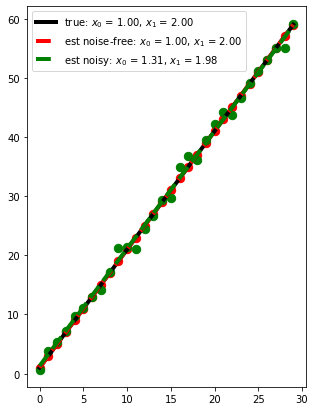

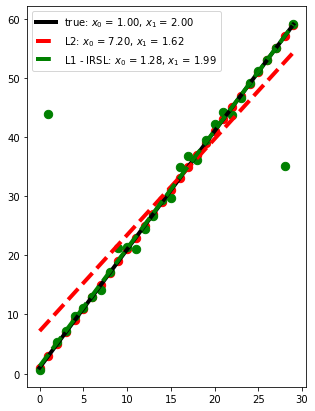

In [8]:
np.random.seed(10)

N = 30
x = cp.array([1., 2.])
sigma = 1

t = np.arange(N, dtype='float64')
tcp = cp.arange(N, dtype='float64')
LRop = LinearRegression(tcp, dtype='float64')

y = LRop * x
yn = y + cp.random.normal(0, sigma, N)

xest = LRop / y
xnest = LRop / yn

plt.figure(figsize=(5, 7))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(x[1]) + cp.asnumpy(x[0]), 'k', lw=4,
         label=r'true: $x_0$ = %.2f, $x_1$ = %.2f' % (x[0], x[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xest[1]) + cp.asnumpy(xest[0]), '--r', lw=4,
         label=r'est noise-free: $x_0$ = %.2f, $x_1$ = %.2f'
         %(xest[0], xest[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xnest[1]) + cp.asnumpy(xnest[0]), '--g', lw=4,
         label=r'est noisy: $x_0$ = %.2f, $x_1$ = %.2f'
         %(xnest[0], xnest[1]))
plt.scatter(cp.asnumpy(t), cp.asnumpy(y), c='r', s=70)
plt.scatter(cp.asnumpy(t), cp.asnumpy(yn), c='g', s=70)
plt.legend()

# Add outliers
yn[1] += 40
yn[N-2] -= 20

# IRLS
nouter = 20
epsR = 5e-3
epsI = 0
tolIRLS = 1e-2

xnest = LRop / yn
xirls, nouter = \
  irls(LRop, yn, nouter=nouter, threshR=False,
       epsR=epsR, epsI=epsI, tolIRLS=tolIRLS, engine='pylops')
print('IRLS converged at %d iterations...' % nouter)

plt.figure(figsize=(5, 7))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(x[1]) + cp.asnumpy(x[0]), 'k', lw=4,
         label=r'true: $x_0$ = %.2f, $x_1$ = %.2f' % (x[0], x[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xnest[1]) + cp.asnumpy(xnest[0]), '--r', lw=4,
         label=r'L2: $x_0$ = %.2f, $x_1$ = %.2f' %
         (xnest[0], xnest[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * cp.asnumpy(xirls[1]) + cp.asnumpy(xirls[0]), '--g', lw=4,
         label=r'L1 - IRSL: $x_0$ = %.2f, $x_1$ = %.2f' %
         (xirls[0], xirls[1]))
plt.scatter(cp.asnumpy(t), cp.asnumpy(y), c='r', s=70)
plt.scatter(cp.asnumpy(t), cp.asnumpy(yn), c='g', s=70)
plt.legend();